In [1]:
## INPUT DATA ##################################################################

# span dimension
span_1          = 20 # in m
poi_required    = 10  # in m, point of interest from left support for max. forces

# load values and dimensions
load_list    = [145, 145, 35] # in kN
spacing_list = [4.3, 4.3]   # in m

# step size for placing moving load
div_len = 0.1 # in m

In [2]:
# @title
import pandas as pd
import numpy as np
from itertools import accumulate
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from IPython.display import clear_output
from IPython.display import Image
from IPython.display import HTML
import matplotlib.animation as animation
import matplotlib as mpl

In [3]:
# @title
## All Functions

# draw figure for vehicular loading

def draw_arrows_with_spacing(heights, spacings):

    if len(spacings) != len(heights) - 1:
        raise ValueError("Length of spacings must be one less than length of heights")

    sf_1 = sum(spacing_list)/max(load_list)*4 # scale factor for diagram
    sf_2 = 10

    fig, ax = plt.subplots(figsize=(8,6), dpi=150)

    # Arrow properties relative to height
    arrows_x = [0]  # first arrow at x=0
    for s in spacings:
        arrows_x.append(arrows_x[-1] + s)

    # Draw arrows
    for i, h in enumerate(heights):
        head_length = 2
        head_width  = 1.5
        x = arrows_x[i]

        # Draw arrow
        ax.arrow(x * sf_2, h * sf_1, 0, -h * sf_1,
                 head_width=head_width, head_length=head_length,
                 fc='black', ec='black', linewidth=2)

        # Label arrow height
        ax.text(x * sf_2, h * sf_1 + 0.05*h * sf_1, f"{h} kN",
                ha='center', va='bottom', fontsize=12, color='black')

    # Draw spacing dimension lines
    dim_y = -0.2 * max(heights)  # place dimension line below arrows
    for i, s in enumerate(spacings):
        x1, x2 = arrows_x[i] * sf_2, arrows_x[i+1] * sf_2
        ax.plot([x1, x2], [dim_y, dim_y], 'k-', linewidth=1)  # horizontal line
        ax.plot([x1, x1], [dim_y, dim_y+0.1*max(heights)], 'k-', linewidth=1)  # left tick
        ax.plot([x2, x2], [dim_y, dim_y+0.1*max(heights)], 'k-', linewidth=1)  # right tick
        ax.text((x1+x2)/2, dim_y - 0.05*max(heights), f"{s} m",
                ha='center', va='top', fontsize=12, color='black')

    # Axis limits
    ax.set_xlim(-1, arrows_x[-1] * sf_2 + 1)
    ax.set_ylim(-0.5*max(heights), max(heights)+0.5*max(heights))

    # Equal aspect ratio
    ax.set_aspect('equal', adjustable='box')

    # Hide axes
    ax.axis('off')
    plt.title("LOADING DIAGRAM")
    plt.show()

# draw figure for beam span

def equilateral_triangle(apex, side_length, orientation="down"):

    h = np.sqrt(3)/2 * side_length
    x0, y0 = apex

    if orientation == "down":
        p1 = (x0 - side_length/2, y0 - h)
        p2 = (x0 + side_length/2, y0 - h)
    else:
        p1 = (x0 - side_length/2, y0 + h)
        p2 = (x0 + side_length/2, y0 + h)

    return np.array([p1, p2, apex, p1])

def box_function(x, a, b):
    return np.where((x >= a) & (x <= b), 1, 0)

def box_function_1(x, a, b):
    return np.where((x > a) & (x <= b), 1, 0)

def box_function_2(x, a, b):
    return np.where((x >= a) & (x < b), 1, 0)

# define function for showing figure with beam span for any specific POI

def beam_with_point_loads(loads, spacings, span_length, position, poi_pos):

    if len(spacings) != len(loads) - 1:
        raise ValueError("Length of spacings must be one less than length of loads")

    # Beam endpoints
    p1 = (0, 0)
    p2 = (span_length, 0)

    fig, ax = plt.subplots(figsize=(10,5), dpi=150)

    # Beam line
    ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 'k-', linewidth=2)

    # Supports
    tri1 = equilateral_triangle(p1, side_length=0.5, orientation="down")
    tri2 = equilateral_triangle(p2, side_length=0.5, orientation="down")
    ax.plot(tri1[:,0], tri1[:,1], 'b-')
    ax.plot(tri2[:,0], tri2[:,1], 'b-')

    # Arrow positions along beam (no scaling)
    arrows_x = [0]
    for s in spacings:
        arrows_x.append(arrows_x[-1] + s)

    sf_y = 0.2  # vertical scaling

    # Draw loads
    for i, h in enumerate(loads):
        x = arrows_x[i] + position   # shift horizontally by position
        ax.arrow(x, np.log2(h)*sf_y + 0.3, 0, -np.log2(h)*sf_y,
                 head_width=0.2, head_length=0.3,
                 fc='black', ec='black', linewidth=2)
        ax.text(x, np.log2(h)*sf_y + 0.05*np.log2(h)*sf_y + 0.3, f"{h} kN",
                ha='center', va='bottom', fontsize=10, color='black')

    if poi_pos is not None:
        circle = plt.Circle((poi_pos, 0), 0.3, color='red', fill=False, linewidth=2)
        ax.add_patch(circle)
        ax.text(poi_pos, -0.6, f"POI @ {poi_pos} m", ha='center', color='red', fontsize=9)


    # Formatting
    ax.set_xlim(-arrows_x[-1]-1, span_length+arrows_x[-1]+1)
    ax.set_ylim(-2, max(np.log2(loads))*sf_y + 2)
    ax.set_aspect('equal', adjustable='box')

    # Show x-axis and finer grid
    ax.get_yaxis().set_visible(False)   # hide y-axis only
    ax.set_xlabel("Beam length (m)")
    ax.grid(True, linestyle='--', alpha=0.6)

    # Set finer grid spacing
    ax.xaxis.set_major_locator(MultipleLocator(2))   # grid every 2 m
    ax.xaxis.set_minor_locator(MultipleLocator(0.2)) # finer grid every 0.5 m
    ax.grid(which='minor', linestyle=':', alpha=0.4) # lighter minor grid

    ax.set_title("Position for maximum effects")
    plt.show()

# beam drawing function
def beam_with_point_loads_1(loads, spacings, span_length, position, ax):
    if len(spacings) != len(loads) - 1:
        raise ValueError("Length of spacings must be one less than length of loads")

    ax.clear()
    p1, p2 = (0,0), (span_length,0)
    ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 'k-', linewidth=2)

    # Supports
    tri1 = equilateral_triangle(p1, side_length=0.3, orientation="down")
    tri2 = equilateral_triangle(p2, side_length=0.3, orientation="down")
    ax.plot(tri1[:,0], tri1[:,1], 'b-')
    ax.plot(tri2[:,0], tri2[:,1], 'b-')

    # Arrow positions
    arrows_x = [0]
    for s in spacings:
        arrows_x.append(arrows_x[-1] + s)

    sf_y = 0.2
    for i, h in enumerate(loads):
        x = arrows_x[i] + position
        ax.arrow(x, np.log2(h)*sf_y + 0.3, 0, -np.log2(h)*sf_y,
                 head_width=0.2, head_length=0.3,
                 fc='black', ec='black', linewidth=2)
        ax.text(x, np.log2(h)*sf_y + 0.05*np.log2(h)*sf_y + 0.3, f"{h} kN",
                ha='center', va='bottom', fontsize=10, color='black')

    ax.set_xlim(-1, span_length+1)
    ax.set_ylim(-2, max(np.log2(loads))*sf_y + 2)
    ax.set_aspect('equal', adjustable='box')
    ax.get_yaxis().set_visible(False)
    ax.set_xlabel("Beam length (m)")
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.xaxis.set_major_locator(MultipleLocator(2))
    ax.xaxis.set_minor_locator(MultipleLocator(0.2))
    ax.grid(which='minor', linestyle=':', alpha=0.4)

def update(frame):
    pos_max_idx_bm = x_cord_1[frame]

    # Beam diagram
    beam_with_point_loads_1(load_list, spacing_list, span_1, pos_max_idx_bm, ax_beam)
    ax_beam.set_title(f"Moving Load Position = {pos_max_idx_bm:.2f} m")

    # Shear force diagram
    ax_sfd.clear()
    ax_sfd.plot(x_cord_span, sf_pos_poi[frame], 'b-', linewidth=2)
    ax_sfd.axhline(0, color='black', linewidth=1)
    ax_sfd.set_ylabel("Shear Force (kN)")
    ax_sfd.set_xlim(0, span_1)
    ax_sfd.grid(True, linestyle='--', alpha=0.6)

    # Bending moment diagram
    ax_bmd.clear()
    ax_bmd.plot(x_cord_span, bm_pos_poi[frame], 'r-', linewidth=2)
    ax_bmd.axhline(0, color='black', linewidth=1)
    ax_bmd.set_ylabel("Bending Moment (kNm)")
    ax_bmd.set_xlabel("Beam length (m)")
    ax_bmd.set_xlim(0, span_1)
    ax_bmd.grid(True, linestyle='--', alpha=0.6)

    return ax_beam, ax_sfd, ax_bmd

# function for sf and bm influence lines

def influence_all(x_vals, y_vals, span_1, load_list_last):

    sf_inf_all = []
    for y in y_vals:
# Vectorized computation for SF influence lines
        sf_x   = ( - x_vals / span_1) * box_function(x_vals, 0, y) + ( 1 - x_vals / span_1) * box_function(x_vals, y, span_1)
        sf_x   = np.concatenate([np.zeros(load_list_last), sf_x, np.zeros(load_list_last)])
        sf_inf_all.append(sf_x)
    bm_inf_all = []
    for y in y_vals:
# Computation for BM influence lines
        bm_x   = (1 - x_vals / span_1) * y - (y - x_vals) * box_function(x_vals, 0, y)
        bm_x   = np.concatenate([np.zeros(load_list_last), bm_x, np.zeros(load_list_last)])
        bm_inf_all.append(bm_x)

    return sf_inf_all, bm_inf_all


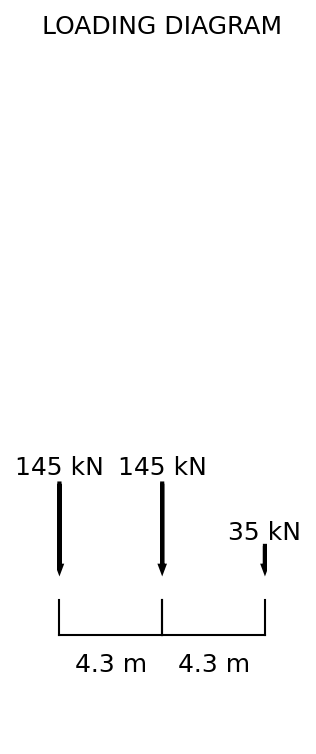

In [4]:
# @title
# Draw Loading Diagram
draw_arrows_with_spacing(heights=load_list, spacings=spacing_list)

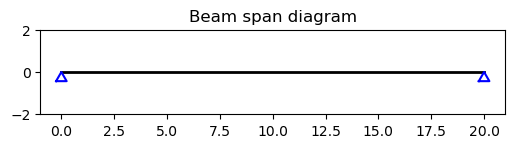

In [5]:
# @title
# draw figure for beam span

# Line endpoints
p1 = (0, 0)
p2 = (span_1, 0)

# Triangles at both ends
tri1 = equilateral_triangle(p1, side_length=0.5, orientation="down")
tri2 = equilateral_triangle(p2, side_length=0.5, orientation="down")

# Plot
plt.figure(figsize=(6,4))
plt.plot([p1[0], p2[0]], [p1[1], p2[1]], 'k-', linewidth=2)
plt.plot(tri1[:,0], tri1[:,1], 'b-')
plt.plot(tri2[:,0], tri2[:,1], 'b-')

# Formatting
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(False)
plt.title("Beam span diagram")

# Increase vertical offsets for clarity
plt.ylim(-2, 2)   # more breathing room above and below
plt.xlim(-1, span_1+1)  # extra horizontal margin too

plt.show()


In [6]:
# @title
# calculate no of divisions on span with specified step size
no_div  = int((span_1)/div_len+1)
load_len = sum(spacing_list)

# converting list to numpy array
load_list           = np.array(load_list)
spacing_list        = np.array(spacing_list)

# list of load position coordinates relative to left load
positions           = np.concatenate(([0], np.cumsum(spacing_list)))

# convert positions array to finer step size
load_position_list  = np.arange(0, positions[-1] + div_len, div_len)
no_div_load         = len(load_position_list)

# create list of indices for finer positions array
load_idx_finer      = np.arange(0, no_div_load, 1)

# create load list corresponding to finer positions array
fine_loads          = np.zeros_like(load_position_list, dtype=float)
indices             = np.searchsorted(load_position_list, positions)
fine_loads[indices] = load_list

# create list of indices for finer positions array
load_idx_finer      = np.arange(0, no_div_load, 1)

indices_loads       = np.nonzero(fine_loads)[0]

# create and store influence line diagrams for different POI

load_idx_list  = indices_loads
load_list_last = load_idx_list[-1]
tot_no_div     = (load_list_last * 2 + no_div)
x_cord_span    = np.arange(0, span_1 + div_len, div_len)
x_cord_span    = np.round(x_cord_span,3)

x_cord         = np.arange(-load_list_last * div_len, (tot_no_div-load_list_last)* div_len, div_len)
x_cord         = np.round(x_cord,3)

step_no        = no_div + load_list_last
x_cord_1       = x_cord[0:step_no]

# Create arrays of x and y positions
x_vals = np.arange(no_div) * div_len
y_vals = np.arange(no_div) * div_len
# Computation for SF influence lines

sf_inf_all, bm_inf_all = influence_all(x_vals, y_vals, span_1, load_list_last)

Max BM = 1246.592 kN-m 
BM Max Occurs at x= 10.7 m and When Last Load is Placed at x= 6.4 m


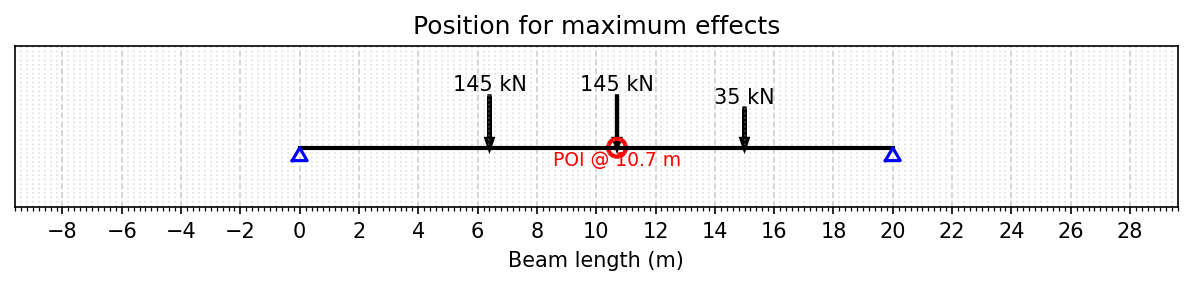

Max SF = 278.775 kN 
SF Max Occurs at x= 0.0 m and When Last Load is Placed at x= -0.0 m


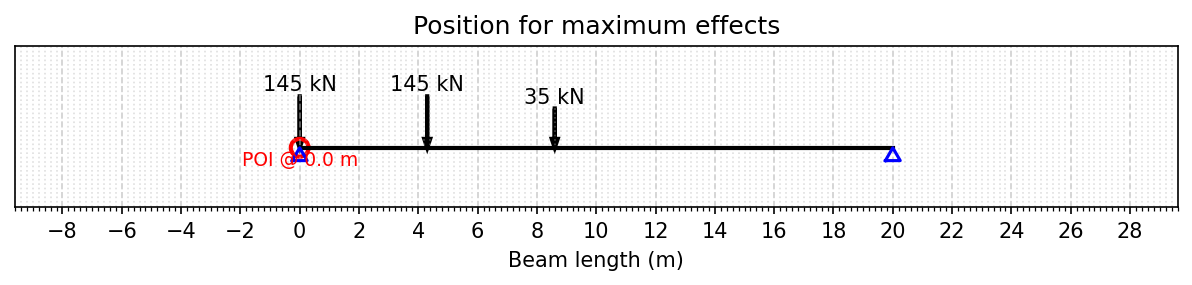

In [7]:
# @title
# Convert lists to NumPy arrays
bm_i_list         = []
sf_i_list         = []
pos_max_i_list_bm = []
pos_max_i_list_sf = []
bm_poi_pos        = []
sf_poi_pos        = []
for i in range(no_div): # looping across different POI
    poi_pos    = x_cord_span[i]

    bm_inf_i   = bm_inf_all[i]
    sf_inf_i   = sf_inf_all[i]

    bm_j_list = []
    sf_j_list = []
    for j in range(step_no): # looping across different load positions
        pos                         = x_cord[j]
        load_array                  = np.zeros(tot_no_div)
        load_array[j:j+no_div_load] = fine_loads

        bm_j                        = np.dot(load_array, bm_inf_i)
        bm_j                        = np.round(bm_j,3)
        bm_j_list.append(bm_j)

        sf_j                        = np.dot(load_array, sf_inf_i)
        sf_j                        = np.round(sf_j,3)
        sf_j_list.append(sf_j)

    bm_poi_pos.append(bm_j_list)
    pos_max_i_bm = x_cord[np.argmax(bm_j_list)]
    pos_max_i_list_bm.append(pos_max_i_bm)
    bm_i      = max(bm_j_list)
    bm_i_list.append(bm_i)

    sf_poi_pos.append(sf_j_list)
    pos_max_i_sf = x_cord[np.argmax(sf_j_list)]
    pos_max_i_list_sf.append(pos_max_i_sf)
    sf_i      = max(sf_j_list)
    sf_i_list.append(sf_i)

pos_max_all_bm     = pos_max_i_list_bm[np.argmax(bm_i_list)]
poi_pos_max_bm     = x_cord_span[np.argmax(bm_i_list)]
print(f"Max BM = {max(bm_i_list)} kN-m \nBM Max Occurs at x= {poi_pos_max_bm} m and When Last Load is Placed at x= {pos_max_all_bm} m")
beam_with_point_loads(load_list, spacing_list, span_1, pos_max_all_bm, poi_pos_max_bm)

pos_max_all_sf     = pos_max_i_list_sf[np.argmax(sf_i_list)]
poi_pos_max_sf     = x_cord_span[np.argmax(sf_i_list)]
print(f"Max SF = {max(sf_i_list)} kN \nSF Max Occurs at x= {poi_pos_max_sf} m and When Last Load is Placed at x= {pos_max_all_sf} m")
beam_with_point_loads(load_list, spacing_list, span_1, pos_max_all_sf, poi_pos_max_sf)


With POI at x = 10 m, Max BM is = 1238.0 kN-m and Occurs When Last Load is Placed at x= 5.7 m


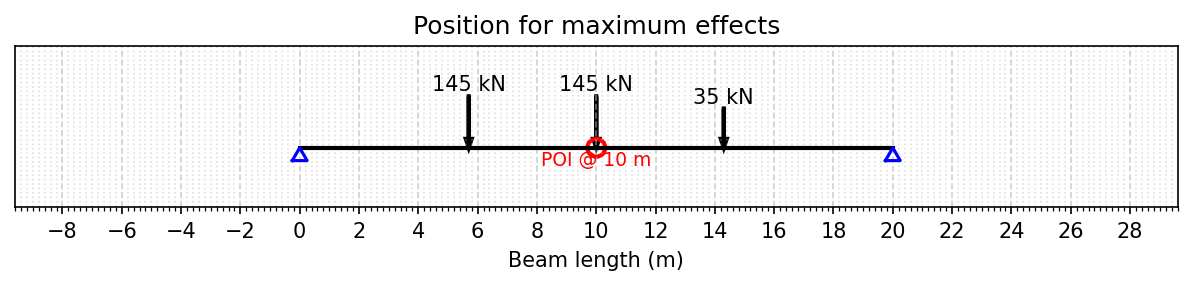

With POI at x = 10 m, Max SF is = 114.65 kN and Occurs When Last Load is Placed at x= 10.1 m


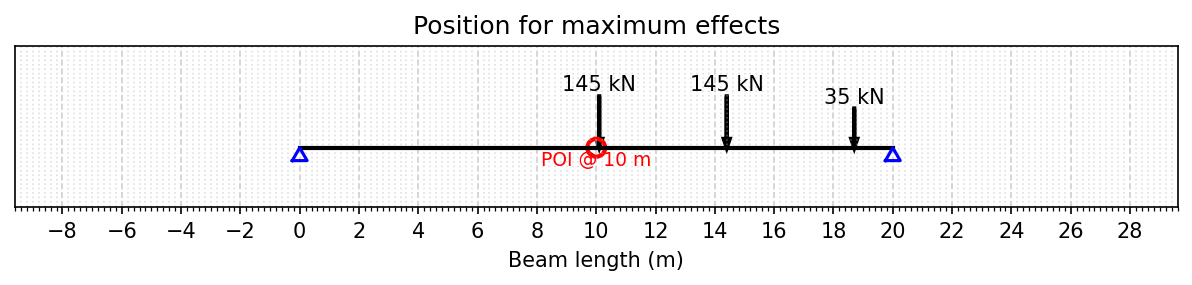

In [8]:
# @title
index           = np.where(x_cord_span == poi_required)[0][0]

pos_max_idx_bm  = pos_max_i_list_bm[index]
bm_max_idx      = bm_i_list[index]

pos_max_idx_sf  = pos_max_i_list_sf[index]
sf_max_idx      = sf_i_list[index]

print(f"With POI at x = {poi_required} m, Max BM is = {bm_max_idx} kN-m and Occurs When Last Load is Placed at x= {pos_max_idx_bm} m")
beam_with_point_loads(load_list, spacing_list, span_1, pos_max_idx_bm, poi_required)

print(f"With POI at x = {poi_required} m, Max SF is = {sf_max_idx} kN and Occurs When Last Load is Placed at x= {pos_max_idx_sf} m")
beam_with_point_loads(load_list, spacing_list, span_1, pos_max_idx_sf, poi_required)


In [9]:
# @title
bm_pos_poi = list(map(list, zip(*bm_poi_pos)))
sf_pos_poi = list(map(list, zip(*sf_poi_pos)))

In [10]:
# @title
# --- Create figure with 3 subplots ---
fig, (ax_beam, ax_sfd, ax_bmd) = plt.subplots(3, 1, figsize=(10,10), dpi=150)


mpl.rcParams['animation.embed_limit'] = 100  # allows up to 100 MB, increase if memory error pops up


ani = animation.FuncAnimation(fig, update, frames=len(x_cord_1), interval=200, blit=False, repeat=True);
plt.close(fig)   # prevents duplicate static output

#HTML(ani.to_jshtml())

